# World Data League 2021
## Notebook Template

This notebook is one of the mandatory deliverables when you submit your solution (alongside the video pitch). Its structure follows the WDL evaluation criteria and it has dedicated cells where you can add descriptions. Make sure your code is readable as it will be the only technical support the jury will have to evaluate your work.

The notebook must:

*   💻 have all the code that you want the jury to evaluate
*   🧱 follow the predefined structure
*   📄 have markdown descriptions where you find necessary
*   👀 be saved with all the output that you want the jury to see
*   🏃‍♂️ be runnable


## Authors
- Nicholas Sistovaris
- Moritz Geiger
- Pravalika Myneni
- Sowmya Madela

## External links and resources

All the external data or resources that was not provided by the WDL was acquired through the following links:

1. https://noise-planet.org/noisemodelling.html 
2. https://www.torinocitylab.it/en/asset-to/open-data 
3. https://www.officeholidays.com/countries/italy/turin/2018 
4. https://www.feiertagskalender.ch/index.php?geo=3815&jahr=2018&hl=en
5. http://webgis.arpa.piemonte.it/basicviewer_arpa_webapp/index.html?webmap=89aa175451d24ae0a1911e67957d9aec
6. http://aperto.comune.torino.it/dataset/zone-statistiche
7. https://openweathermap.org/history
8. https://developers.google.com/maps/documentation/places/web-service/details 
9. https://www.cirrusresearch.co.uk/blog/2013/01/noise-data-averaging-how-do-i-average-noise-measurements/

## Introduction

**Overview:**


_from challenge description_
<blockquote>

</blockquote>



**Research:**



## Development
Start coding here! 👩‍💻

Don't hesitate to create markdown cells to include descriptions of your work where you see fit, as well as commenting your code.

We know that you know exactly where to start when it comes to crunching data and building models, but don't forget that WDL is all about social impact...so take that into consideration as well.

In [1]:
!pip install geopandas
!pip install dotenv
!pip install pmdarima

  Using cached https://files.pythonhosted.org/packages/e2/46/3754073706e31670eed18bfa8a879305b56a471db15f20523c2427b10078/dotenv-0.0.5.tar.gz
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.


### Imports (libraries) 📚

In [2]:
## TABULAR
import pandas as pd 
import numpy as np
import matplotlib

## GEO
import geopandas as gpd
import fiona
import folium
from folium.plugins import MarkerCluster, HeatMap, BeautifyIcon
from folium.map import LayerControl, Layer, FeatureGroup
from folium.vector_layers import Circle, CircleMarker
from shapely.geometry import LineString, Point
from shapely import wkt


## DATA
import os
import zipfile
from collections import Counter
import re
from datetime import datetime
import requests
#from dotenv import load_dotenv, find_dotenv
import ast
import datetime as dt
from io import StringIO, BytesIO


## VIS
from ipywidgets import interact, interactive, fixed, interact_manual, IntSlider
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.tsa
import branca
import plotly.express as px

## TIME SERIES
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima 


## MODELLING
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor as rfr

## NEURAL NETWORKS
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

### Importing Dataframes

Following a first glance at the dataframes provided by the WDL, we believed that using data from **2018** was our best bet to construct our model on. 

- First, we wanted to focus on understanding noise and complaints in the pre-covid context. The years 2020 and 2021 would have been unrepresentative of Turin's nightlife.

- Secondly, we wanted a feature that would represent the number of people outsides on an hourly basis. The data on No. of Visitors based on WiFi was most complete and representative of the population outside. However, it only had data for October, November & December 2018. This is why we picked 2018 for the rest of our data.

In [98]:
# location of the sensors
df_sensors_def = pd.read_csv('https://raw.githubusercontent.com/McNickSisto/world_data_league/main/stage_final/data/noise_sensor_list.csv', sep=';')
df_sensors_def

,code,address,Lat,Long,streaming
0,s_01,"Via Saluzzo, 26 Torino","45,059172","7,678986",https://userportal.smartdatanet.it/userportal/...
1,s_02,"Via Principe Tommaso, 18bis Torino","45,057837","7,681555",https://userportal.smartdatanet.it/userportal/...
2,s_03,Largo Saluzzo Torino,"45,058518","7,678854",https://userportal.smartdatanet.it/userportal/...
3,s_05,Via Principe Tommaso angolo via Baretti Torino,"45,057603","7,681348",https://userportal.smartdatanet.it/userportal/...
4,s_06,"Corso Marconi, 27 Torino","45,055554","7,68259",https://userportal.smartdatanet.it/userportal/...


**Note** The location of sensors was optimized to cover all
significant feature of “Movida” area:
one in a very crowded square (S_03, not active in
daytime), three in narrow streets with pubs and
bars (S_01, S_04, S_05), one in a boulevard for
traffic noise measurement (S_06) and the last one
in a quieter area with no crowd and low traffic
(S_02), for global reference. The choice of points
of installation was driven also by the power
supply, so light poles, public offices and bike
sharing station where preferred.

Source: https://wdl-data.fra1.digitaloceanspaces.com/torino/120_Euronoise2018.pdf

In [99]:
df_wifi = pd.read_csv('https://raw.githubusercontent.com/McNickSisto/world_data_league/main/stage_final/data/WIFI%20Count.csv', sep=',')
df_wifi.head()

,Time,No. of Visitors
0,2018-10-24 17:00,47
1,2018-10-24 18:00,155
2,2018-10-24 19:00,181
3,2018-10-24 20:00,211
4,2018-10-24 21:00,239


**Note** As you can see, from the data above, we can get an idea of the number of people outside at different hours.

In [100]:
df_businesses = pd.read_csv('https://raw.githubusercontent.com/McNickSisto/world_data_league/main/stage_final/data/businesses.csv', sep=';')
df_businesses.head()

,WKT,ADDRESS,OPEN YEAR,OPEN MONTH,TYPE,Description,Merchandise Type
0,POINT (1396322.217 4990301.69),VIA CLAUDIO LUIGI BERTHOLLET 24,1977,1,EXTRALIMENTARI,PICCOLE STRUTTURE,Extralimentari
1,POINT (1396322.217 4990301.69),VIA CLAUDIO LUIGI BERTHOLLET 24,1985,6,ALIMENTARI,PICCOLE STRUTTURE,Panificio
2,POINT (1396303.762 4990325.001),VIA CLAUDIO LUIGI BERTHOLLET 25/F,2017,9,ALTRO,DIA di somministrazione,Nessuna
3,POINT (1396434.395 4990540.6),CORSO VITTORIO EMANUELE II 21/A,2013,10,ALTRO,DIA di somministrazione,Nessuna
4,POINT (1396434.395 4990540.6),CORSO VITTORIO EMANUELE II 21/A,2009,2,ALTRO,DIA di somministrazione,Nessuna


**Note** Location & Description of various businesses 

In [101]:
df_sim_june = pd.read_csv('https://raw.githubusercontent.com/McNickSisto/world_data_league/main/stage_final/data/sim_count/SIM_count_04_100618.csv', sep=';', encoding='latin-1')
df_sim_june.head()

,cluster,data_da,data_a,numero_presenze,layer_id,layer_nome,dettaglio(secondi)
0,Presenze,2018-06-10T21:00:00Z,2018-06-10T22:00:00Z,3278,5491d6d2-0c9e-47b7-bfde-c84c632efacc,Area 1,3600
1,Presenze,2018-06-10T20:00:00Z,2018-06-10T21:00:00Z,3324,5491d6d2-0c9e-47b7-bfde-c84c632efacc,Area 1,3600
2,Presenze,2018-06-10T19:00:00Z,2018-06-10T20:00:00Z,3318,5491d6d2-0c9e-47b7-bfde-c84c632efacc,Area 1,3600
3,Presenze,2018-06-10T18:00:00Z,2018-06-10T19:00:00Z,3187,5491d6d2-0c9e-47b7-bfde-c84c632efacc,Area 1,3600
4,Presenze,2018-06-10T17:00:00Z,2018-06-10T18:00:00Z,2980,5491d6d2-0c9e-47b7-bfde-c84c632efacc,Area 1,3600


In [102]:
df_sim_jan = pd.read_csv('https://raw.githubusercontent.com/McNickSisto/world_data_league/main/stage_final/data/sim_count/SIM_count_15_210118.csv', sep=';', encoding='latin-1')
df_sim_jan.head()

,cluster,data_da,data_a,numero_presenze,layer_id,layer_nome,dettaglio(secondi)
0,Presenze,2018-01-21T22:00:00Z,2018-01-21T23:00:00Z,3026,5491d6d2-0c9e-47b7-bfde-c84c632efacc,Area 1,3600
1,Presenze,2018-01-21T21:00:00Z,2018-01-21T22:00:00Z,3088,5491d6d2-0c9e-47b7-bfde-c84c632efacc,Area 1,3600
2,Presenze,2018-01-21T20:00:00Z,2018-01-21T21:00:00Z,3119,5491d6d2-0c9e-47b7-bfde-c84c632efacc,Area 1,3600
3,Presenze,2018-01-21T19:00:00Z,2018-01-21T20:00:00Z,3114,5491d6d2-0c9e-47b7-bfde-c84c632efacc,Area 1,3600
4,Presenze,2018-01-21T18:00:00Z,2018-01-21T19:00:00Z,2991,5491d6d2-0c9e-47b7-bfde-c84c632efacc,Area 1,3600


In [103]:
df_sim_march = pd.read_csv('https://raw.githubusercontent.com/McNickSisto/world_data_league/main/stage_final/data/sim_count/SIM_count_19_250318.csv', sep=';', encoding='latin-1')
df_sim_march.head()

,cluster,data_da,data_a,numero_presenze,layer_id,layer_nome,dettaglio(secondi)
0,Presenze,2018-03-25T21:00:00Z,2018-03-25T22:00:00Z,3267,5491d6d2-0c9e-47b7-bfde-c84c632efacc,Area 1,3600
1,Presenze,2018-03-25T20:00:00Z,2018-03-25T21:00:00Z,3373,5491d6d2-0c9e-47b7-bfde-c84c632efacc,Area 1,3600
2,Presenze,2018-03-25T19:00:00Z,2018-03-25T20:00:00Z,3410,5491d6d2-0c9e-47b7-bfde-c84c632efacc,Area 1,3600
3,Presenze,2018-03-25T18:00:00Z,2018-03-25T19:00:00Z,3358,5491d6d2-0c9e-47b7-bfde-c84c632efacc,Area 1,3600
4,Presenze,2018-03-25T17:00:00Z,2018-03-25T18:00:00Z,3229,5491d6d2-0c9e-47b7-bfde-c84c632efacc,Area 1,3600


In [104]:
df_sim_all = pd.concat([df_sim_jan, df_sim_march, df_sim_june], axis=0)
df_sim_all.reset_index(inplace=True)

**Note** Another possibility to estimate the number of people outside at certain hours is the SIM card dataframes. What it highlights is the presence of certain SIM card users at different hours of the day. We have access to SIM card data of 2018 for January, March and June.

In [105]:
df_noise_2018 = pd.read_csv('https://raw.githubusercontent.com/McNickSisto/world_data_league/main/stage_final/data/noise_data/Noise_Data_2018.csv')
df_noise_2018=df_noise_2018.drop(columns='Unnamed: 0')
df_noise_2018.astype('str')
df_noise_2018.head()

,Data,Ora,C1,C2,C3,C4,C5
0,01-01-2018,00:00,"68,7",NaN,"76,0",NaN,"66,6"
1,01-01-2018,01:00,"68,3",NaN,"68,2",NaN,"65,4"
2,01-01-2018,02:00,"59,8",NaN,"64,4",NaN,"64,4"
3,01-01-2018,03:00,"67,4",NaN,"67,5",NaN,"61,8"
4,01-01-2018,04:00,"68,0",NaN,"64,5",NaN,"60,5"


In [106]:
df_noise_2018['date_hour'] = df_noise_2018['Data'] + ' ' + df_noise_2018['Ora']
df_noise_2018['date_hour'] = pd.to_datetime(df_noise_2018['date_hour'])
df_noise_2018.head(2)

,Data,Ora,C1,C2,C3,C4,C5,date_hour
0,01-01-2018,00:00,"68,7",NaN,"76,0",NaN,"66,6",2018-01-01 00:00:00
1,01-01-2018,01:00,"68,3",NaN,"68,2",NaN,"65,4",2018-01-01 01:00:00


**Note** The noise data is records of noice measurements using 5 different sensors spread in the San Salvario region on an hourly basis. We will use this data as our target in our time series measurements. 

**Preprocessing Noise Data**


1.   TypeCasting the data values to required format (COnverting data and Ora to Date and Hour format)
2.   Converting the noise readings into decimal format (68,7 to 68.7 etc)
3.   TypeCastig the noise values
4.   Imputing the null values based on day and hour
5.   Considering the logarithmic mean of all noise reading at each day and hour





In [107]:
#Typecasting the data
df_noise_2018['Ora']=pd.to_datetime(df_noise_2018['Ora']).dt.hour        #Changing the hour format
df_noise_2018['Data']=pd.to_datetime(df_noise_2018['Data'])     #Changing the date format
#Converting the noise readings into decimal format
df_noise_2018['C1']=df_noise_2018['C1'].apply(lambda x: str(x).replace(',','.'))
df_noise_2018['C2']=df_noise_2018['C2'].apply(lambda x: str(x).replace(',','.'))
df_noise_2018['C3']=df_noise_2018['C3'].apply(lambda x: str(x).replace(',','.'))
df_noise_2018['C4']=df_noise_2018['C4'].apply(lambda x: str(x).replace(',','.'))
df_noise_2018['C5']=df_noise_2018['C5'].apply(lambda x: str(x).replace(',','.'))
df_noise_2018.head(2)

,Data,Ora,C1,C2,C3,C4,C5,date_hour
0,2018-01-01,0,68.7,nan,76.0,nan,66.6,2018-01-01 00:00:00
1,2018-01-01,1,68.3,nan,68.2,nan,65.4,2018-01-01 01:00:00


In [108]:
#Conerting the noise reading to float values
df_noise_2018['C1']=df_noise_2018['C1'].apply(lambda x: float(x))
df_noise_2018['C2']=df_noise_2018['C2'].apply(lambda x: float(x))
df_noise_2018['C3']=df_noise_2018['C3'].apply(lambda x: float(x))
df_noise_2018['C4']=df_noise_2018['C4'].apply(lambda x: float(x))
df_noise_2018['C5']=df_noise_2018['C5'].apply(lambda x: float(x))

In [109]:
#Adding day value like Monday as 0, Tuseday as 1 etc to the noise data based on date
df_noise_2018['day']=df_noise_2018['Data'].dt.dayofweek

The missing values are filled with respective to particular day and hour. For instance to fill the null value of saturday at 1:00, mean of all the saturdays at 1:00 hour is considered

In [110]:
#Fillig the null values considering means on hourly basis
df_noise_2018["C1"] = df_noise_2018.groupby(["Ora",'day'])['C1'].transform(lambda x: x.fillna(round(x.mean(),1)))
df_noise_2018["C2"] = df_noise_2018.groupby(["Ora",'day'])['C2'].transform(lambda x: x.fillna(round(x.mean(),1)))
df_noise_2018["C3"] = df_noise_2018.groupby(["Ora",'day'])['C3'].transform(lambda x: x.fillna(round(x.mean(),1)))
df_noise_2018["C4"] = df_noise_2018.groupby(["Ora",'day'])['C4'].transform(lambda x: x.fillna(round(x.mean(),1)))
df_noise_2018["C5"] = df_noise_2018.groupby(["Ora",'day'])['C5'].transform(lambda x: x.fillna(round(x.mean(),1)))
#Let's Check if there are any null values after filling
df_noise_2018.isnull().sum()

Data         0
Ora          0
C1           0
C2           0
C3           0
C4           0
C5           0
date_hour    0
day          0
dtype: int64

Computing logarithimic mean of C1,C2,C3,C4,C5 (all sensors noise readings).

**Why logarithmic mean??**
Simple averaging can be produced will not represent the level of energy of a record. For example, 45, 46, 48, 43, 78, 79, 71, 33, 55 levels, the simple arithmetic average would be 55.3.

But the energy level of noise for 78, 79 and 71 is high compared to other values so this can be solved by considering the logarithmic average.

The steps involved in computing the logarithmic average include

1.   Divide each value by 10
2.   Apply anti log
3.   Add all the values
4.   Divide by total number of samples
5.   base 10 log the number and multiply it by 10




In [111]:
df_noise_2018['Log_Avg']=np.log10(((10**(df_noise_2018['C1']/10))+(10**(df_noise_2018['C2']/10))+(10**(df_noise_2018['C3']/10))+(10**(df_noise_2018['C4']/10))+(10**(df_noise_2018['C5']/10)))/5)*10
df_noise_2018.head(2)

,Data,Ora,C1,C2,C3,C4,C5,date_hour,day,Log_Avg
0,2018-01-01,0,68.7,56.6,76.0,58.8,66.6,2018-01-01 00:00:00,0,70.253908
1,2018-01-01,1,68.3,53.6,68.2,55.7,65.4,2018-01-01 01:00:00,0,65.424707


In [112]:
df_police_1 = pd.read_excel('https://github.com/McNickSisto/world_data_league/blob/main/stage_final/data/police_complaints/OpenDataContact_Gennaio_Giugno_2018.xlsx?raw=true')
df_police_1.head()

,Categoria criminologa,Sottocategoria Criminologica,Circoscrizione,Localita,Area Verde,Data,Ora
0,Allarme Sociale,Altro,6.0,BELMONTE/(VIA),NaN,01/02/2018,NaN
1,Allarme Sociale,Altro,6.0,DONATORE DI SANGUE/(PIAZZA DEL),NaN,12/02/2018,NaN
2,Allarme Sociale,Altro,4.0,CIBRARIO/LUIGI (VIA),NaN,26/02/2018,NaN
3,Allarme Sociale,Altro,1.0,ROMA/(VIA),NaN,02/03/2018,NaN
4,Allarme Sociale,Altro,4.0,ZUMAGLIA/(VIA),NaN,05/03/2018,NaN


In [113]:
df_police_2 = pd.read_csv('https://raw.githubusercontent.com/McNickSisto/world_data_league/main/stage_final/data/police_complaints/OpenDataContact_Luglio_Dicembre_2018.csv')
df_police_2.head()

,Categoria criminologa,Sottocategoria Criminologica,Circoscrizione,Localita,Area Verde,Data,Ora
0,Allarme Sociale,Altro,8.0,D'AZEGLIO/MASSIMO (CORSO) ...,NaN,16/07/2018,NaN
1,Allarme Sociale,Altro,1.0,REGINA MARGHERITA/(CORSO) ...,NaN,17/07/2018,NaN
2,Allarme Sociale,Altro,10.0,DUINO/(VIA) ...,NaN,14/09/2018,NaN
3,Allarme Sociale,Altro,NaN,NaN,NaN,02/10/2018,9.40
4,Allarme Sociale,Altro,9.0,CARDUCCI/GIOSUE' (PIAZZA) ...,NaN,27/11/2018,11.53


In [114]:
df_police = pd.concat([df_police_1,df_police_2])
df_police.head()

,Categoria criminologa,Sottocategoria Criminologica,Circoscrizione,Localita,Area Verde,Data,Ora
0,Allarme Sociale,Altro,6.0,BELMONTE/(VIA),NaN,01/02/2018,NaN
1,Allarme Sociale,Altro,6.0,DONATORE DI SANGUE/(PIAZZA DEL),NaN,12/02/2018,NaN
2,Allarme Sociale,Altro,4.0,CIBRARIO/LUIGI (VIA),NaN,26/02/2018,NaN
3,Allarme Sociale,Altro,1.0,ROMA/(VIA),NaN,02/03/2018,NaN
4,Allarme Sociale,Altro,4.0,ZUMAGLIA/(VIA),NaN,05/03/2018,NaN


In [115]:
df_weather = pd.read_csv("https://raw.githubusercontent.com/McNickSisto/world_data_league/main/stage_final/data/all_weather.csv")
df_weather = df_weather.drop(columns = ['Unnamed: 0'])
df_weather.head()

,time,temp,winds,rainfall_mm,snowfall_mm
0,2018-01-01 00:00:00,1.04,0.366667,-0.010,2.600000
1,2018-01-01 01:00:00,1.09,0.590000,0.009,2.600000
2,2018-01-01 02:00:00,1.05,0.450000,0.008,2.266667
3,2018-01-01 03:00:00,0.89,0.400000,0.006,2.266667
4,2018-01-01 04:00:00,0.73,0.780000,-0.011,2.300000


<br><br>
See details in [Appendix](#Weather Data)

In [116]:
#List of holidays
df_holidays = pd.read_csv('https://raw.githubusercontent.com/McNickSisto/world_data_league/main/stage_final/holidays.csv')
df_holidays

,Date,Day,Holiday
0,01-01-2018,monday,New year's Day
1,06-01-2018,saturday,La Befana
2,19-03-2018,monday,Father's day
3,25-03-2018,sunday,Palm Sunday
4,01-04-2018,sunday,Easter
5,02-04-2018,monday,Easter Monday
6,25-04-2018,wednesday,liberation
7,01-05-2018,tuesday,Labour day
8,09-05-2018,wednesday,Europe day
9,13-05-2018,sunday,mother's day


In [ ]:
df_matches = pd.read_csv('GET MATCHES')
df_matches

FileNotFoundError: [Errno 2] No such file or directory: 'GET MATCHES'

In [ ]:
df_opening_hours = pd.read_csv('GET OPENING HOURS')

### Merging Dataframes

In [117]:
df_noise_2018['date_hour'] = df_noise_2018['date_hour'].dt.strftime("%d-%m-%y %H:%M")
df_noise_2018.head()

,Data,Ora,C1,C2,C3,C4,C5,date_hour,day,Log_Avg
0,2018-01-01,0,68.7,56.6,76.0,58.8,66.6,01-01-18 00:00,0,70.253908
1,2018-01-01,1,68.3,53.6,68.2,55.7,65.4,01-01-18 01:00,0,65.424707
2,2018-01-01,2,59.8,51.2,64.4,53.0,64.4,01-01-18 02:00,0,61.332068
3,2018-01-01,3,67.4,47.5,67.5,48.7,61.8,01-01-18 03:00,0,64.069742
4,2018-01-01,4,68.0,47.6,64.5,49.0,60.5,01-01-18 04:00,0,63.175181


In [118]:
df_wifi.rename(columns = {'Time': 'date_time'}, inplace=True)
df_wifi.columns

Index(['date_time', 'No. of Visitors'], dtype='object')

In [119]:
df_wifi['date_time'] = pd.to_datetime(df_wifi['date_time'])
df_wifi['date_time'] = df_wifi['date_time'].dt.strftime("%d-%m-%y %H:%M")

In [120]:
df_weather['time'] = pd.to_datetime(df_weather['time'])
df_weather['time'] = df_weather['time'].dt.strftime("%d-%m-%y %H:%M")

In [121]:
for x, line in enumerate(df_sim_all['data_da']):
    df_sim_all['data_da'][x] = line[8:10] + line[4:7] + '-' + line[0:4] +' ' + line[11:16]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [122]:
df_sim_all.rename(columns= {'data_da' : 'date_time'}, inplace=True)
df_sim_all.columns

Index(['index', 'cluster', 'date_time', 'data_a', 'numero_presenze',
       'layer_id', 'layer_nome', 'dettaglio(secondi)'],
      dtype='object')

In [123]:
df_sim_all['date_time'] = pd.to_datetime(df_sim_all['date_time'])
df_sim_all['date_time'] = df_sim_all['date_time'].dt.strftime("%d-%m-%y %H:%M")
df_sim_all.head(2)

,index,cluster,date_time,data_a,numero_presenze,layer_id,layer_nome,dettaglio(secondi)
0,0,Presenze,21-01-18 22:00,2018-01-21T23:00:00Z,3026,5491d6d2-0c9e-47b7-bfde-c84c632efacc,Area 1,3600
1,1,Presenze,21-01-18 21:00,2018-01-21T22:00:00Z,3088,5491d6d2-0c9e-47b7-bfde-c84c632efacc,Area 1,3600


Merging noise, wifi, sim,weather,... police

In [124]:
df_final = df_noise_2018.merge(df_wifi, left_on= 'date_hour', right_on= 'date_time', how='left')
df_final.head(2)

,Data,Ora,C1,C2,C3,C4,C5,date_hour,day,Log_Avg,date_time,No. of Visitors
0,2018-01-01,0,68.7,56.6,76.0,58.8,66.6,01-01-18 00:00,0,70.253908,NaN,NaN
1,2018-01-01,1,68.3,53.6,68.2,55.7,65.4,01-01-18 01:00,0,65.424707,NaN,NaN


In [125]:
df_final_1 = df_final.merge(df_sim_all, left_on= 'date_hour', right_on= 'date_time', how='left')
df_final_1.head(2)

,Data,Ora,C1,C2,C3,C4,C5,date_hour,day,Log_Avg,date_time_x,No. of Visitors,index,cluster,date_time_y,data_a,numero_presenze,layer_id,layer_nome,dettaglio(secondi)
0,2018-01-01,0,68.7,56.6,76.0,58.8,66.6,01-01-18 00:00,0,70.253908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01,1,68.3,53.6,68.2,55.7,65.4,01-01-18 01:00,0,65.424707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
df_final_2 = df_final_1.merge(df_weather, left_on= 'date_hour', right_on= 'time', how='left')
df_final_2.head(2)

,Data,Ora,C1,C2,C3,C4,C5,date_hour,day,Log_Avg,date_time_x,No. of Visitors,index,cluster,date_time_y,data_a,numero_presenze,layer_id,layer_nome,dettaglio(secondi),time,temp,winds,rainfall_mm,snowfall_mm
0,2018-01-01,0,68.7,56.6,76.0,58.8,66.6,01-01-18 00:00,0,70.253908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01-01-18 00:00,1.04,0.366667,-0.010,2.6
1,2018-01-01,1,68.3,53.6,68.2,55.7,65.4,01-01-18 01:00,0,65.424707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01-01-18 01:00,1.09,0.590000,0.009,2.6


In [127]:
df_final_2.columns

Index(['Data', 'Ora', 'C1', 'C2', 'C3', 'C4', 'C5', 'date_hour', 'day',
       'Log_Avg', 'date_time_x', 'No. of Visitors', 'index', 'cluster',
       'date_time_y', 'data_a', 'numero_presenze', 'layer_id', 'layer_nome',
       'dettaglio(secondi)', 'time', 'temp', 'winds', 'rainfall_mm',
       'snowfall_mm'],
      dtype='object')

In [128]:
df_final_3 = df_final_2.drop(columns = ['date_time_x','date_time_y', 'time'] )

In [129]:
df_final_3['date_hour'] = pd.to_datetime(df_final_3['date_hour'])
df_final_3['date'] = df_final_3['date_hour'].dt.strftime("%d-%m-%y")

In [130]:
df_final_3.head(2)

,Data,Ora,C1,C2,C3,C4,C5,date_hour,day,Log_Avg,No. of Visitors,index,cluster,data_a,numero_presenze,layer_id,layer_nome,dettaglio(secondi),temp,winds,rainfall_mm,snowfall_mm,date
0,2018-01-01,0,68.7,56.6,76.0,58.8,66.6,2018-01-01 00:00:00,0,70.253908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.04,0.366667,-0.010,2.6,01-01-18
1,2018-01-01,1,68.3,53.6,68.2,55.7,65.4,2018-01-01 01:00:00,0,65.424707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.09,0.590000,0.009,2.6,01-01-18


In [131]:
df_finalized = df_final_3.merge(df_holidays, left_on='date', right_on = 'Date', how ="left")
df_finalized['isHoliday'] = df_finalized['Holiday'].apply(lambda x: 0 if pd.isnull(x)==True else 1)
df_finalized.head(30)

,Data,Ora,C1,C2,C3,C4,C5,date_hour,day,Log_Avg,No. of Visitors,index,cluster,data_a,numero_presenze,layer_id,layer_nome,dettaglio(secondi),temp,winds,rainfall_mm,snowfall_mm,date,Date,Day,Holiday,isHoliday
0,2018-01-01,0,68.7,56.6,76.0,58.8,66.6,2018-01-01 00:00:00,0,70.253908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.04,0.366667,-0.010,2.600000,01-01-18,NaN,NaN,NaN,0
1,2018-01-01,1,68.3,53.6,68.2,55.7,65.4,2018-01-01 01:00:00,0,65.424707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.09,0.590000,0.009,2.600000,01-01-18,NaN,NaN,NaN,0
2,2018-01-01,2,59.8,51.2,64.4,53.0,64.4,2018-01-01 02:00:00,0,61.332068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.05,0.450000,0.008,2.266667,01-01-18,NaN,NaN,NaN,0
3,2018-01-01,3,67.4,47.5,67.5,48.7,61.8,2018-01-01 03:00:00,0,64.069742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.89,0.400000,0.006,2.266667,01-01-18,NaN,NaN,NaN,0
4,2018-01-01,4,68.0,47.6,64.5,49.0,60.5,2018-01-01 04:00:00,0,63.175181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.73,0.780000,-0.011,2.300000,01-01-18,NaN,NaN,NaN,0
5,2018-01-01,5,55.4,48.3,56.7,50.3,59.5,2018-01-01 05:00:00,0,55.752994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.78,0.550000,-0.014,2.133333,01-01-18,NaN,NaN,NaN,0
6,2018-01-01,6,57.5,52.2,53.2,55.4,58.2,2018-01-01 06:00:00,0,55.898737,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.83,0.630000,-0.011,2.166667,01-01-18,NaN,NaN,NaN,0
7,2018-01-01,7,51.8,59.2,66.3,62.0,57.0,2018-01-01 07:00:00,0,61.664298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,1.220000,-0.014,2.333333,01-01-18,NaN,NaN,NaN,0
8,2018-01-01,8,63.0,61.5,63.4,63.3,55.8,2018-01-01 08:00:00,0,62.102496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.27,1.400000,-0.012,2.000000,01-01-18,NaN,NaN,NaN,0
9,2018-01-01,9,53.8,61.0,64.7,63.9,56.5,2018-01-01 09:00:00,0,61.674007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.28,0.950000,-0.012,2.433333,01-01-18,NaN,NaN,NaN,0


In [132]:
df_finalized = df_finalized.drop(columns= ['Date'])

In [134]:
df_finalized.head()

,Data,Ora,C1,C2,C3,C4,C5,date_hour,day,Log_Avg,No. of Visitors,index,cluster,data_a,numero_presenze,layer_id,layer_nome,dettaglio(secondi),temp,winds,rainfall_mm,snowfall_mm,date,Day,Holiday,isHoliday
0,2018-01-01,0,68.7,56.6,76.0,58.8,66.6,2018-01-01 00:00:00,0,70.253908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.04,0.366667,-0.010,2.600000,01-01-18,NaN,NaN,0
1,2018-01-01,1,68.3,53.6,68.2,55.7,65.4,2018-01-01 01:00:00,0,65.424707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.09,0.590000,0.009,2.600000,01-01-18,NaN,NaN,0
2,2018-01-01,2,59.8,51.2,64.4,53.0,64.4,2018-01-01 02:00:00,0,61.332068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.05,0.450000,0.008,2.266667,01-01-18,NaN,NaN,0
3,2018-01-01,3,67.4,47.5,67.5,48.7,61.8,2018-01-01 03:00:00,0,64.069742,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.89,0.400000,0.006,2.266667,01-01-18,NaN,NaN,0
4,2018-01-01,4,68.0,47.6,64.5,49.0,60.5,2018-01-01 04:00:00,0,63.175181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.73,0.780000,-0.011,2.300000,01-01-18,NaN,NaN,0


In [135]:
df_finalized.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17311 entries, 0 to 17310
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Data                17311 non-null  datetime64[ns]
 1   Ora                 17311 non-null  int64         
 2   C1                  17311 non-null  float64       
 3   C2                  17311 non-null  float64       
 4   C3                  17311 non-null  float64       
 5   C4                  17311 non-null  float64       
 6   C5                  17311 non-null  float64       
 7   date_hour           17311 non-null  datetime64[ns]
 8   day                 17311 non-null  int64         
 9   Log_Avg             17311 non-null  float64       
 10  No. of Visitors     1639 non-null   float64       
 11  index               9054 non-null   float64       
 12  cluster             9054 non-null   object        
 13  data_a              9054 non-null   object    

In [ ]:
#df_finalized.to_csv('Noise_weather_wifi_sim_holidays.csv')

### Correlation Analysis

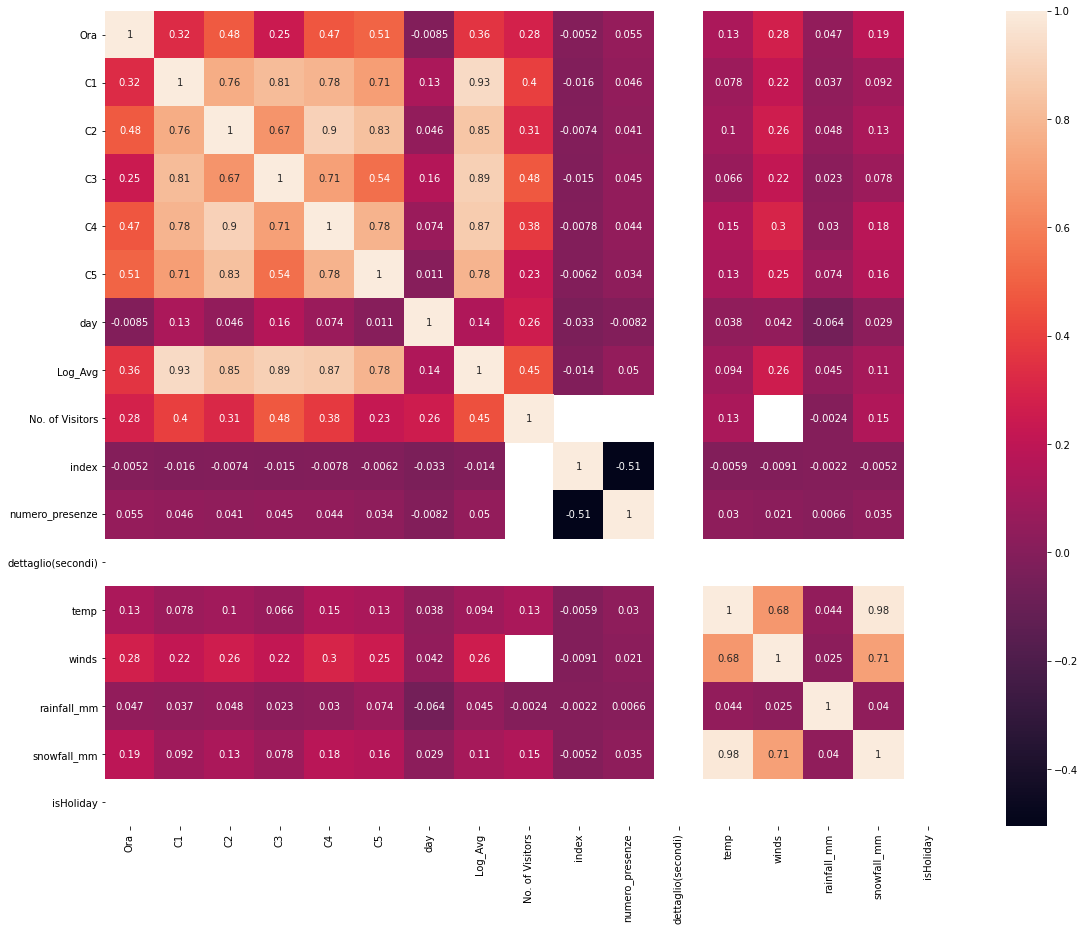

In [138]:
correlation_mat = df_finalized.corr()
f = plt.figure(figsize=(19, 15))
sns.heatmap(correlation_mat, annot = True)
plt.show()

In [141]:
sorted_pairs = corr_pairs.sort_values(kind="quicksort")
strong_pairs = sorted_pairs[abs(sorted_pairs) > 0.7]
strong_pairs

C5               C1                 0.705592
C1               C5                 0.705592
winds            snowfall_mm        0.707306
snowfall_mm      winds              0.707306
C4               C3                 0.709484
C3               C4                 0.709484
C2               C1                 0.757761
C1               C2                 0.757761
C4               C5                 0.780906
C5               C4                 0.780906
                 Log_Avg            0.782721
Log_Avg          C5                 0.782721
C1               C4                 0.784405
C4               C1                 0.784405
C1               C3                 0.812364
C3               C1                 0.812364
C5               C2                 0.830937
C2               C5                 0.830937
Log_Avg          C2                 0.849193
C2               Log_Avg            0.849193
C4               Log_Avg            0.873541
Log_Avg          C4                 0.873541
          

### Data Exploration

In [142]:
df_police[df_police['Ora'].isna()] #many complaints do not have hours associated with them 

,Categoria criminologa,Sottocategoria Criminologica,Circoscrizione,Localita,Area Verde,Data,Ora
0,Allarme Sociale,Altro,6.0,BELMONTE/(VIA),NaN,01/02/2018,NaN
1,Allarme Sociale,Altro,6.0,DONATORE DI SANGUE/(PIAZZA DEL),NaN,12/02/2018,NaN
2,Allarme Sociale,Altro,4.0,CIBRARIO/LUIGI (VIA),NaN,26/02/2018,NaN
3,Allarme Sociale,Altro,1.0,ROMA/(VIA),NaN,02/03/2018,NaN
4,Allarme Sociale,Altro,4.0,ZUMAGLIA/(VIA),NaN,05/03/2018,NaN
...,...,...,...,...,...,...,...
985,Qualità Urbana,Decoro e degrado urbano,3.0,RACCONIGI/(CORSO) ...,NaN,23/12/2018,NaN
986,Qualità Urbana,Decoro e degrado urbano,3.0,MONTE CUCCO/(CORSO) ...,NaN,24/12/2018,NaN
989,Qualità Urbana,Decoro e degrado urbano,8.0,CARDINALE MAURIZIO/(VIA) ...,NaN,28/12/2018,NaN
991,Qualità Urbana,Veicoli abbandonati,4.0,BOSELLI/PAOLO (VIA) ...,NaN,17/09/2018,NaN


In [ ]:
noise_2018=pd.read_csv('raw_data/noise_data/san_salvario_2018.csv',
                       skiprows=8,
                       delimiter=';',
                      decimal=',',
#                       parse_dates=[['Data', 'Ora']],
                      )

# # workaround for hour concat issue
noise_2018['Data'] = pd.to_datetime(noise_2018['Data'], format='%d-%m-%Y', errors='coerce')
noise_2018['date_hour'] = noise_2018.apply(lambda x: pd.to_datetime(str(x.Data) + ' ' + str(x.Ora), errors='coerce'), axis=1)
noise_2018 = noise_2018.drop(columns=['Data', 'Ora'])


noise_2018.info()

In [ ]:
# plot matches with sensor data
match = pd.read_csv('raw_data/football/matches_2018.csv', index_col=0).set_index('Date')
match['is_match'] = match.is_match.apply(lambda x: x+80 if x == 1 else x)
fig = px.line(noise_2018.set_index('date_hour'))
fig.add_scatter(x=match.index, 
                y=match['is_match'], 
                mode='markers',
                name='football match'
               )


### Modelling

#### ARIMA

In [ ]:
data=pd.read_csv('https://raw.githubusercontent.com/McNickSisto/world_data_league/main/stage_final/data/Imputed_Data_Final.csv')
data=data.drop(columns='Unnamed: 0')
data.head(4)

In [ ]:
data_i = data.set_index('date_hour')
data_i.head(2)

In [ ]:
df=data_i['Log_Avg']
df.head(2)

In [ ]:
df.plot(figsize=(20,5))

In [ ]:
additive = seasonal_decompose(df,freq=52, model='additive',extrapolate_trend='freq')

In [ ]:
additive_df = pd.concat([additive.seasonal, additive.trend, additive.resid, additive.observed], axis=1)
additive_df.columns = ['seasonal', 'trend', 'resid', 'actual_values']
additive_df.head()

In [ ]:
plt.rcParams.update({'figure.figsize': (20,10)})
additive.plot().suptitle('Additive Decompose')
#The Trend,residuals are interesting, showing periods of high variability.

In [ ]:
trend = additive.trend
from statsmodels.tsa.stattools import adfuller
result = adfuller(trend.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(trend.values); axes[0, 0].set_title('Original Series')
plot_acf(trend.values, ax=axes[0, 1]).suptitle('Original Series', fontsize=0)
# 1st Differencing
diff1 = trend.diff().dropna()
axes[1, 0].plot(diff1.values)
axes[1, 0].set_title('1st Order Differencing')
plot_acf(diff1.values, ax=axes[1, 1]).suptitle('1st Order Differencing', fontsize=0)
# 2nd Differencing
diff2 = trend.diff().diff().dropna()
axes[2, 0].plot(diff2.values)
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(diff2.values, ax=axes[2, 1]).suptitle('2nd Order Differencing', fontsize=0)

In [ ]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
size = 100
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(diff1.values[:size])
axes[0].set_title('1st Order Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(diff1.values[:size], lags=50, ax=axes[1]).suptitle('1st Order Differencing', fontsize=0)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
train = trend[:3000]
test  = trend[3000:]
# order = (p=1, d=1, q=1)
model = ARIMA(train, order=(1, 1, 1))  
model = model.fit(disp=0)  
print(model.summary())

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])

In [ ]:
fc, se, conf = model.forecast(14311, alpha=0.05)
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

#### Moving Average

In [ ]:
df.head(2)

Moving Average Smoothing is a technique applied to time series to remove the fine-grained variation between time steps. The hope of smoothing is to remove noise and better expose the signal of the underlying causal processes.

In [ ]:
plt.rcParams["figure.figsize"] = (20,6)
df.plot()
pyplot.show()

In [ ]:
# Tail-rolling average transform
rolling = df.rolling(window=3)
rolling_mean = rolling.mean()
rolling_mean.dropna(inplace= True)
print(rolling_mean.head())
# plot original and transformed dataset
df.plot()
rolling_mean.plot(color='lightgreen')
pyplot.show()

In [ ]:
from pandas import read_csv
from numpy import mean
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
# prepare situation
X = df.values
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
	length = len(history)
	yhat = mean([history[i] for i in range(length-window,length)])
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	#print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='lightcoral')
pyplot.show()
# zoom plot
pyplot.plot(test[0:100])
pyplot.plot(predictions[0:100], color='lightcoral')
pyplot.show()

## Conclusions

### Scalability and Impact
Tell us how applicable and scalable your solution is if you were to implement it in a city. Identify possible limitations and measure the potential social impact of your solution.

### Future Work
Now picture the following scenario: imagine you could have access to any type of data that could help you solve this challenge even better. What would that data be and how would it improve your solution? 🚀

# Appendix 

## Weather Data

### Data

In [ ]:
weather = pd.read_csv('raw_data/weather/weather_1.csv',
#                       nrows=1000, #rm later
                      sep=';',
#                       decimal=',',
                      skiprows=4,
#                       parse_dates=[[0, 1]],
#                       dayfirst=True,
                      header=0,
                      names=['date', 'hour', 'rainfall_mm', 'snowfall_mm'],
                     )

# workaround for hour concat issue
weather['date'] = pd.to_datetime(weather['date'], format='%d-%m-%Y', errors='coerce')
weather['date_hour'] = weather.apply(lambda x: pd.to_datetime(str(x.date) + ' ' + str(x.hour), errors='coerce'), axis=1)

# workaround for decimal issue
weather['rainfall_mm'] = weather.rainfall_mm.apply(lambda x: str(x).replace(',','.'))
weather['snowfall_mm'] = weather.snowfall_mm.apply(lambda x: str(x).replace(',','.'))

In [ ]:
weather2 = pd.read_csv('raw_data/weather/weather_2.csv', 
                 sep=';', 
                 skiprows=4, 
                 header=0, 
#                  decimal=',',
#                 converters={2:lambda x: x.replace(',', '.')},
#                 parse_dates=[[0, 1]],
                names=['date', 'hour', 'winds'],
                na_values={2:'',
                            3:''},
                dayfirst=True,
                )
# workaround for hour concat issue
weather2['date'] = pd.to_datetime(weather2['date'], format='%d-%m-%Y', errors='coerce')
weather2['date_hour'] = weather2.apply(lambda x: pd.to_datetime(str(x.date) + ' ' + str(x.hour), errors='coerce'), axis=1)

weather2['winds'] = weather2.winds.apply(lambda x: str(x).replace(',','.'))

In [ ]:
# weather['date_hour'] = pd.to_datetime(weather['date_hour'], errors='coerce')
weather_1 = weather.dropna(subset=['date_hour'])

# weather2['date_hour'] = pd.to_datetime(weather2['date_hour'], errors='coerce')
weather_2 = weather2.dropna(subset=['date_hour'])

In [ ]:
merged_weather = weather_2.merge(weather_1,
                                right_on='date_hour',
                                left_on='date_hour',
                                )

In [ ]:
merged_weather.sort_values(by='date_hour').tail()

In [ ]:
merged_weather['hourly_date'] = merged_weather.date_hour.apply(lambda x: x.floor('h'))

In [ ]:
merged_weather = merged_weather.astype({'winds': float,
                      'rainfall_mm':float,
                      'snowfall_mm':float})

In [ ]:
hourly_weather = merged_weather.groupby('hourly_date').mean()

In [ ]:
hourly_weather.info()

In [ ]:
hourly_weather.to_csv('hourly_weather.csv')

In [ ]:
hourly_weather.head()

### Open Weather Map

In [ ]:
# API KEY
load_dotenv(find_dotenv())
OWM_API = os.environ.get("OWM_API")

In [ ]:
# init time range
range_2019 = pd.DataFrame(pd.date_range('2016-06-01', '2021-06-12', freq='h'), columns=['hour'])
range_2019.tail().hour

In [ ]:
req = 'http://history.openweathermap.org/data/2.5/history/wdl'
start = range_2019.hour.min().value
inter = range_2019.hour.max().value
end = range_2019.hour.max().value
# tail1 = tail.min().value
# tail2 = tail.max().value
params = {
    'id':'3165524', # ID of Turin
    'type':'hour',
    'start':str(start)[:10], # unix time
    'end':str(end)[:10],
    'appid': OWM_API
}

r = requests.get(req, params=params)


# with open('data/weather.txt', 'w') as outfile:
#     json.dump(r.json(), outfile)
    
weather = r.json()
lst = weather.get('list')
dct = {x.get('dt'):x.get('weather')[0].get('main') for x in lst}
weather_df = pd.DataFrame.from_dict(dct, 
                                    orient='index', 
                                    columns=['weather']).reset_index().rename(columns={'index':'time'})
weather_df['rain'] = weather_df.weather == 'Rain'

In [ ]:
lst = weather.get('list')
dct = {x.get('dt'):x.get('main').get('temp') for x in lst}

In [ ]:
weather_df = pd.DataFrame.from_dict(dct, 
                                    orient='index', 
                                    columns=['temp']).reset_index().rename(columns={'index':'time'})
weather_df['temp'] = weather_df.temp-273.15
weather_df['time'] = pd.to_datetime(weather_df.time, unit='s')

In [ ]:
weather_df.info()

In [ ]:
merge_all = weather_df.merge(hourly_weather, left_on='time', right_index=True)

In [ ]:
merge_all.to_csv('all_weather.csv')

In [ ]:
merge_all

## Matches Data

In [ ]:
# API KEY
load_dotenv(find_dotenv())
FOOTBALL = os.environ.get("FOOTBALL")

In [ ]:
# headers = {'X-Auth-Token': FOOTBALL}
# url = 'https://api.football-data.org/v2/matches'
# params = {'dateFrom': '2018-04-14',
#          'dateTo': '2018-04-16'}
# r = requests.get(url, headers=headers, params=params)
# r.json()

In [ ]:
root = 'raw_data/football/'
dfs = []
for i in os.listdir(root):
    if '.csv' in i:
        df = pd.read_csv(root+i)
        dfs.append(df)

In [ ]:
# filter all by juve
juve1 = dfs[0][(dfs[0]['HomeTeam'] == 'Juventus') \
              | (dfs[0]['AwayTeam'] == 'Juventus')]['Date']
juve1 = pd.to_datetime(juve1, format='%d/%m/%Y')

juve2 = dfs[1][(dfs[1]['Home Team'] == 'Juventus') \
               | (dfs[1]['Away Team'] == 'Juventus')]['Date']
juve2 = pd.to_datetime(juve2.apply(lambda x: x[:10]), format="%d/%m/%Y")

juve3 = dfs[2][(dfs[2]['HomeTeam'] == 'Juventus') \
              | (dfs[2]['AwayTeam'] == 'Juventus')]['Date']
juve3 = pd.to_datetime(juve3, format='%d/%m/%y')

juve4 = dfs[3][(dfs[3]['Home Team'] == 'Juventus') \
               | (dfs[3]['Away Team'] == 'Juventus')]['Date']
juve4 = pd.to_datetime(juve4.apply(lambda x: x[:10]), format="%d/%m/%Y")

In [ ]:
# concat all dates
all_concat = pd.DataFrame(pd.concat([juve1, juve2, juve3, juve4]))
# all_concat['Date'] = pd.to_datetime(all_concat.Date)
all_concat['is_match'] = 1

In [ ]:
all_concat.sort_values(by='Date')

In [ ]:
# get all 2018 matches
all_concat_2018 = all_concat[(all_concat.Date > '01-01-2018') \
                            & (all_concat.Date < '2018-12-31')]

In [ ]:
# put in 2018 time series
r = pd.date_range('2018-01-01', '2018-12-31', freq='h')
matches = all_concat_2018.set_index('Date').reindex(r).rename_axis('Date').reset_index()

In [ ]:
matches.head()

In [ ]:
matches.to_csv('raw_data/football/matches_2018.csv')

## Opening Hours Data

This part is a bit messy, so we will explain: 
We used the ```nearbysearch``` [Link](https://developers.google.com/maps/documentation/places/web-service/search#PlaceSearchRequests) to get all the ```bars``` and ```restaurants``` business hours. 

Then we fetch the unique id ```reference``` from the list of businesses and run it through the ```place_details``` API [Link](https://developers.google.com/maps/documentation/places/web-service/details)

From there we extract all the ```open``` (time-)elements and ```close``` (time-)elements and stack them in a dataframe divided by days of the week (0-6). 

In the end we merge the findings with an empty time series of 2018 with an 'hourly' sequence. 


In [ ]:
# API KEY
load_dotenv(find_dotenv())
GOOGLE = os.environ.get("GOOGLE")

In [ ]:
# first find all bars

url = 'https://maps.googleapis.com/maps/api/place/nearbysearch/json'
params = {            
            'location':'45.05917,7.67899', #sensor
            'radius':'200',
            'type':'restaurant',
            'key':GOOGLE,
            'next_page_token':'Aap_uED24ODLIlOhPdAHG7xFrCg_OrsQ_jAruvTm3QSG4Qbnp5Q85Aa4K7ar-QgnGI7Xnl1epc9YIEj17piMfVpFUxQysBwi8XTzdWbtl6IBGKTKQwV_kxhaAUWr8JG6XVo-BVKHd8NJUwiTP-_uQvkKxc5vLZ4-v6T8ZBuS42zw5DE1L2KgNPCbm86EsPhPYOj8L1MXTRdEm_GhmQSdOt8nDxG4gKkbxiXvmHNTmuBLavqN-VrbpkRBBoVZz_t2P53_ShPgndMEwlt55EYlZHCYK2gHymy9WJjMjKn3VzS6CfcTQJ-TjgsxsrRjSqNXV4T5i2qusSJ__gsam11RBY8XRADB31i-ec_wYCh1529gNKKy9tdQbidVaQjAI72wQ-7yzTZXGzxpz8ob_DHkdVdyJLxijWoHqsXY7oQM-W3Db0u08SHwaooMyb3Da9Ij'
         } 

r = requests.get(url, params=params)
r.json()

In [ ]:
results = r.json().get('results')
results2 = r.json().get('results')
results3 = r.json().get('results')
results4 = r.json().get('results')
results5 = r.json().get('results')
results6 = r.json().get('results')

In [ ]:
bars = results + results2 + results3 + results4 + results5 + results6
restaurants = results + results2 + results3 + results4 + results5 + results6
len(restaurants)

In [ ]:
# get specific opening hrs from fetched bars/restaurants
url = 'https://maps.googleapis.com/maps/api/place/details/json'
params = {
    'key':GOOGLE,
    'fields':'opening_hours'
         }
opening_hrs = []
for bar in restaurants:
    reference = bar.get('reference')
    params['place_id'] = reference
    r = requests.get(url, params=params)
    opening_hrs.append(r)

In [ ]:
contents_hrs = [r.json() for r in opening_hrs]
periods = []
for x in contents_hrs:
    try:
        hr = x.get('result').get('opening_hours').get('periods')
        periods.append(hr)
    except:
        pass

In [ ]:
# remove 24h open bars
new = [x for x in periods if len(x) > 1]

In [ ]:
closing = []
for x in new:
    for i in x:
        _close = i.get('close')
        closing.append(_close)
opening = []
for x in new:
    for i in x:
        _open = i.get('open')
        opening.append(_open)

In [ ]:
opening_times_rest = pd.DataFrame(opening)
closing_times_rest = pd.DataFrame(closing)
closing_times_rest['time'] = pd.to_datetime(closing_times_rest['time'], format='%H%M')
opening_times_rest['time'] = pd.to_datetime(opening_times_rest['time'], format='%H%M')
closing_times_rest['day'] = closing_times_rest.day.apply(lambda x: x-1 if x != 0 else 6)
opening_times_rest['day'] = opening_times_rest.day.apply(lambda x: x-1 if x != 0 else 6)

In [ ]:
# create unique day_hr identifier
closing_times_rest['day_time'] = closing_times_rest.apply(lambda x: str(x.day) + '_' + str(x.time.hour), axis=1)
opening_times_rest['day_time'] = opening_times_rest.apply(lambda x: str(x.day) + '_' + str(x.time.hour), axis=1)

In [ ]:
# put results in dataframe
opening_times = pd.DataFrame(opening)
closing_times = pd.DataFrame(closing)
closing_times['time'] = pd.to_datetime(closing_times['time'], format='%H%M')
opening_times['time'] = pd.to_datetime(opening_times['time'], format='%H%M')
closing_times['day'] = closing_times.day.apply(lambda x: x-1 if x != 0 else 6)
opening_times['day'] = opening_times.day.apply(lambda x: x-1 if x != 0 else 6)

In [ ]:
# create unique day_hr identifier
closing_times['day_time'] = closing_times.apply(lambda x: str(x.day) + '_' + str(x.time.hour), axis=1)
opening_times['day_time'] = opening_times.apply(lambda x: str(x.day) + '_' + str(x.time.hour), axis=1)

In [ ]:
closing_all = pd.concat([closing_times_rest, closing_times])
opening_all = pd.concat([opening_times_rest, opening_times])

In [ ]:
# count all apperances of openings and closings per weekday
agg_close = closing_all.groupby('day_time').agg({'day':'count'}).rename(columns={'day':'count_close'})
agg_open = opening_all.groupby('day_time').agg({'day':'count'}).rename(columns={'day':'count_open'})
agg_joint = agg_close.join(agg_open, how='outer')

In [ ]:
# init range 2018
range_2018 = pd.DataFrame(pd.date_range('2018-01-01', '2018-12-31', freq='h'), columns=['hour'])
range_2018['day_time'] =  range_2018.apply(lambda x: str(x.hour.weekday()) + '_' + str(x.hour.hour), axis=1)

In [ ]:
# join both

opening_count_2018 = range_2018.merge(agg_joint, 
                                    on='day_time',
                                    how='left').drop(columns='day_time')

In [ ]:
opening_times

In [ ]:
opening_count_2018.sort_values(by='count_open')

In [ ]:
opening_count_2018.to_csv('raw_data/opening_count_2018.csv')

# Modelling 

##Preprocessing the final dataframe

In [ ]:
df_merged = pd.read_csv('https://raw.githubusercontent.com/McNickSisto/world_data_league/main/stage_final/data/Noise_weather_wifi_sim_holidays_opencount_complaints_logvalues.csv')
df_merged = df_merged.drop(columns=['Unnamed: 0'])

For now let us consider log_avg (logarithmic average of C1, C2, C3, C4, C5), temp, rainfall, snowfall, isholiday, complaints_no, count_close, count_open

In [ ]:
df_reg_1 = df_merged[['date_hour', 'temp', 'winds', 'rainfall_mm', 'snowfall_mm', 'isHoliday', 'date', 'hour', 'day', 'Log_Avg', 'Complaints_no', 'count_close']]
df_reg_1 = df_reg_1.fillna(value={'count_close' : 0, 'winds' : 0, 'snowfall_mm':0 , 'rainfall_mm' : 0})
df_reg_1['date_hour'] = pd.to_datetime(df_reg_1['date_hour'])
df_reg_1 =  df_reg_1.set_index('date_hour')

In [ ]:
cor = df_reg_1.corr()
cor['Log_Avg'].sort_values()

In [ ]:
df_close = df_reg_1.copy()

## Getting Log_Avg values of previous times

In [ ]:
def create_regressor_attributes(df, attribute, list_of_prev_t_instants) :
    
    list_of_prev_t_instants.sort()
    start = list_of_prev_t_instants[-1] 
    end = len(df)
    df['datetime'] = df.index
    df.reset_index(drop=True)

    df_copy = df[start:end]
    df_copy.reset_index(inplace=True, drop=True)

    for attribute in attribute :
            foobar = pd.DataFrame()

            for prev_t in list_of_prev_t_instants :
                new_col = pd.DataFrame(df[attribute].iloc[(start - prev_t) : (end - prev_t)])
                new_col.reset_index(drop=True, inplace=True)
                new_col.rename(columns={attribute : '{}_(t-{})'.format(attribute, prev_t)}, inplace=True)
                foobar = pd.concat([foobar, new_col], sort=False, axis=1)

            df_copy = pd.concat([df_copy, foobar], sort=False, axis=1)
            
    df_copy.set_index(['datetime'], drop=True, inplace=True)
    return df_copy

In [ ]:
list_of_attributes = ['Log_Avg']

list_of_prev_t_instants = []
for i in range(24,361,24): #we can change this list as list of times with most impact
    list_of_prev_t_instants.append(i)

list_of_prev_t_instants

In [ ]:
df_new = create_regressor_attributes(df_close, list_of_attributes, list_of_prev_t_instants)
df_new.head()

In [ ]:
df_new.corr()['Log_Avg'].sort_values()

Probably we should do some more preprocessing. Currently I am sticking to just the modelling. Later on we can change it accordingly

In [ ]:
df_new_1 = df_new[['Log_Avg', 'Log_Avg_(t-24)',
       'Log_Avg_(t-48)', 'Log_Avg_(t-72)', 'Log_Avg_(t-96)', 'Log_Avg_(t-120)',
       'Log_Avg_(t-144)', 'Log_Avg_(t-168)', 'Log_Avg_(t-192)','Log_Avg_(t-216)', 'Log_Avg_(t-240)',
       'temp', 'winds', 'rainfall_mm', 'snowfall_mm', 'isHoliday', 
       'hour', 'day',  'Complaints_no', 'count_close']]

##Spliting the dataset into train, validation and test sets

In [ ]:
test_set_size = 0.05
valid_set_size= 0.05

df_copy = df_new_1.reset_index(drop=True)

df_test = df_copy.iloc[ int(np.floor(len(df_copy)*(1-test_set_size))) : ]
df_train_plus_valid = df_copy.iloc[ : int(np.floor(len(df_copy)*(1-test_set_size))) ]

df_train = df_train_plus_valid.iloc[ : int(np.floor(len(df_train_plus_valid)*(1-valid_set_size))) ]
df_valid = df_train_plus_valid.iloc[ int(np.floor(len(df_train_plus_valid)*(1-valid_set_size))) : ]


X_train, y_train = df_train.iloc[:, 1:], df_train.iloc[:, 0]
X_valid, y_valid = df_valid.iloc[:, 1:], df_valid.iloc[:, 0]
X_test, y_test = df_test.iloc[:, 1:], df_test.iloc[:, 0]

print('Shape of training inputs, training target:', X_train.shape, y_train.shape)
print('Shape of validation inputs, validation target:', X_valid.shape, y_valid.shape)
print('Shape of test inputs, test target:', X_test.shape, y_test.shape)

## Implementing a minmaxscaler ## we can skip this

In [ ]:
Target_scaler = MinMaxScaler(feature_range=(0.01, 0.99)) 
Feature_scaler = MinMaxScaler(feature_range=(0.01, 0.99))

X_train_scaled = Feature_scaler.fit_transform(np.array(X_train))
X_valid_scaled = Feature_scaler.fit_transform(np.array(X_valid))
X_test_scaled = Feature_scaler.fit_transform(np.array(X_test))

y_train_scaled = Target_scaler.fit_transform(np.array(y_train).reshape(-1,1))
y_valid_scaled = Target_scaler.fit_transform(np.array(y_valid).reshape(-1,1))
y_test_scaled = Target_scaler.fit_transform(np.array(y_test).reshape(-1,1))

## Modelling

currently adding all the model, based on the score we can use the top model and move the rest to appendix or delete them

### Linear Regression

In [ ]:
Lin_reg = LinearRegression()
Lin_reg.fit(X_train_scaled, y_train_scaled)
y_pred = Lin_reg.predict(X_test_scaled)
y_pred_rescaled = Target_scaler.inverse_transform(y_pred)

y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)
score = r2_score(y_test_rescaled, y_pred_rescaled)
print('R-squared score for the test set: ', round(score,4))


### Ridge Regression

In [ ]:
ridge = Ridge(alpha=0.5)
ridge.fit(X_train_scaled, y_train_scaled)
y_pred = ridge.predict(X_test_scaled)
y_pred_rescaled = Target_scaler.inverse_transform(y_pred)

y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)
score = r2_score(y_test_rescaled, y_pred_rescaled)
print('R-squared score for the test set: ', round(score,4))


### Lasso Regression

In [ ]:

Lasso = Lasso(alpha=0.2, fit_intercept=True, normalize=False, precompute=False, max_iter=1000,
              tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')
Lasso.fit(X_train_scaled, y_train_scaled)
y_pred = Lasso.predict(X_test_scaled)
y_pred_rescaled = Target_scaler.inverse_transform(y_pred.reshape(-1,1))

y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)
score = r2_score(y_test_rescaled, y_pred_rescaled)
print('R-squared score for the test set: ', round(score,4))


### Decision Tree regression

In [ ]:
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train_scaled, y_train_scaled)
y_pred = tree_model.predict(X_test_scaled)
y_pred_rescaled = Target_scaler.inverse_transform(y_pred.reshape(-1,1))

y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)
score = r2_score(y_test_rescaled, y_pred_rescaled)
print('R-squared score for the test set: ', round(score,4))

### Random Forest Regressor

In [ ]:
Rfr = rfr(n_estimators = 100, criterion = 'mse',
                              random_state = 1,
                              n_jobs = -1)
Rfr.fit(X_train_scaled, y_train_scaled)
y_pred = Rfr.predict(X_test_scaled)
y_pred_rescaled = Target_scaler.inverse_transform(y_pred.reshape(-1,1))

y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)
score = r2_score(y_test_rescaled, y_pred_rescaled)
print('R-squared score for the test set: ', round(score,4))


###Polynomial Regression

In [ ]:
pol = PolynomialFeatures (degree = 2)
x_pol = pol.fit_transform(X_train)
Pol_reg = LinearRegression()
Pol_reg.fit(X_train_scaled, y_train_scaled)
y_pred = Pol_reg.predict(X_test_scaled)
y_pred_rescaled = Target_scaler.inverse_transform(y_pred.reshape(-1,1))

y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)
score = r2_score(y_test_rescaled, y_pred_rescaled)
print('R-squared score for the test set: ', round(score,4))

### Basic Neural Network

In [ ]:
model_nn = keras.Sequential([
  # the hidden layer
   layers.Dense(64, activation='sigmoid'),
    # the linear output layer 
    layers.Dense(units=1, input_shape=[X_train_scaled.shape[1]])
])
model_nn.compile(loss= 'mean_squared_error', optimizer='adam')
history_nn = model_nn.fit(X_train_scaled, y_train_scaled, epochs=50)

y_pred = model_nn.predict(X_test_scaled)
y_pred_rescaled = Target_scaler.inverse_transform(y_pred.reshape(-1,1))

y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)
score = r2_score(y_test_rescaled, y_pred_rescaled)
print('R-squared score for the test set: ', round(score,4))

###LSTM RNN

#### Preprocessing for LSTM RNN

In [ ]:
X_train_lstm = np.reshape(X_train_scaled,(X_train_scaled.shape[0], X_train_scaled.shape[1],1) )
y_train_lstm = np.reshape(y_train_scaled, (y_train_scaled.shape[0]))

X_valid_lstm = np.reshape(X_valid_scaled,(X_valid_scaled.shape[0], X_valid_scaled.shape[1],1) )
y_valid_lstm = np.reshape(y_valid_scaled, (y_valid_scaled.shape[0]))

X_test_lstm = np.reshape(X_test_scaled,(X_test_scaled.shape[0], X_test_scaled.shape[1],1) )
y_test_lstm = np.reshape(y_test_scaled, (y_test_scaled.shape[0]))


In [ ]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

In [ ]:
model.fit(x=X_train_lstm, y=y_train_lstm, batch_size=5, epochs=30, verbose=1, validation_data=(X_valid_lstm, y_valid_lstm), shuffle=True)

In [ ]:
loss_per_epoch = model.history.history['loss']
val_loss_per_epoch = model.history.history['val_loss']

In [ ]:
y_pred = model.predict(X_test_lstm)
y_pred_rescaled = Target_scaler.inverse_transform(y_pred)
y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)
score = r2_score(y_test_rescaled, y_pred_rescaled)

#### Plotting loss values ##can skip this if we are not using LSTM 

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(loss_per_epoch);
plt.plot(val_loss_per_epoch);
plt.title("LSTM model loss in MSE");
plt.ylabel("loss");
plt.xlabel("Epochs");
plt.legend(['train', 'val']);

In [ ]:
y_axis = list(df_new_1.index)[-854:]
y_actual = pd.DataFrame(y_test_rescaled, columns=['Actual'])
y_hat = pd.DataFrame(y_pred_rescaled, columns=['Predicted'])
positions = [0,100,200,300,400,500,600,700,800]
selected_labels = []
for i in positions:
  selected_labels.append(y_axis[i])

plt.figure(figsize=(18, 10))
plt.plot(y_actual, linestyle='solid', color='r')
plt.plot(y_hat, linestyle='dashed', color='b')
plt.xticks(positions, selected_labels)
plt.legend(['Actual','Predicted'], loc='best', prop={'size': 14})
plt.title('SSTA in test', weight='bold', fontsize=16)
plt.grid(color = 'y', linewidth='0.5')
plt.show()